In [ ]:
Team Members: Sashi Gandavarapu & Raghu Pamidimarri

Questions:
    1. Why is knn better than Naive Bayes, LR, SVM? kNN works well with large sample size and fewer features. 
    2. How about NV, LR - Why do they not perform well? Even with GridSearch, they are not good. 
    3. Why is Random Forest the best here?
    4. Does any amount of tuning help other algorithms?
    5. Identify all the stuff that you can tune.
    
    
Kaggle board results:
1. Without any new features, RandomForest (estimators = 100, max_features = 9) => 0.735
2. Without any new features, ExtraRandomForest (estimators = 200, max_features = 9) => 0.736
3. With new features, ExtraRandomForest (estimators = 400, max_features = 9) => 0.739
4. PCA => 0.69
 
 Things to try :
 a) Come up with new features + extra tress classifier => 0.7396
 b) PCA => 0.69. Tried PCA with different combinations (after adding more important features, with/without tuning, etc. does not give good values).
 c) Try tweaking more parameters of the RandomForestClassifier - explore the parameters it outputs.


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
#import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [36]:
#Read data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sampleSubmission = pd.read_csv("sampleSubmission.csv")

target = 'Cover_Type'

#shuffle train data
train = train.sample(frac=1.0)

print 'Shape of training data:', train.shape
print 'Shape of test data:', test.shape
print 'Frequency of target values:', train.Cover_Type.value_counts()
#print 'columns:', train.columns
#print 'first value:', train.values[0]


Shape of training data: (15120, 56)
Shape of test data: (565892, 55)
Frequency of target values: 7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64


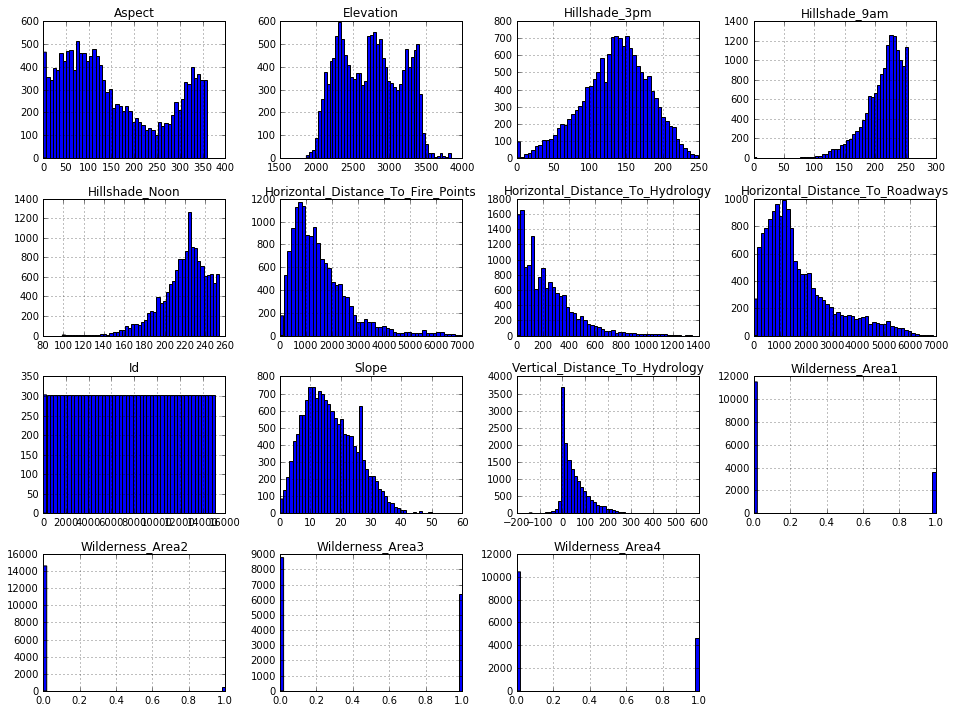

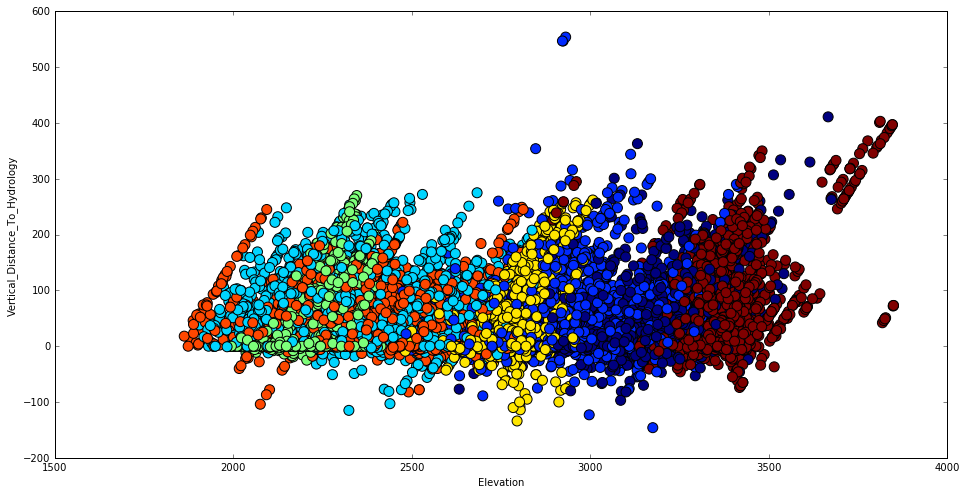

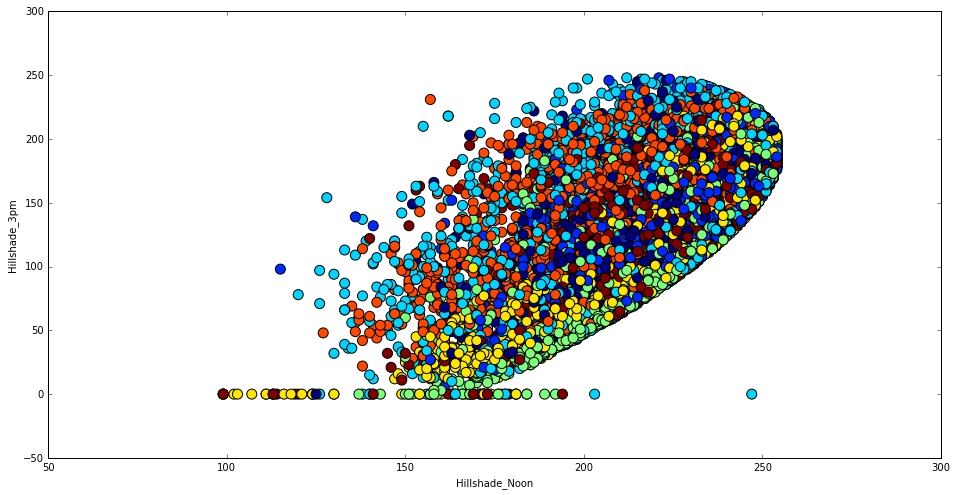

In [37]:
#Visualize the data
train.ix[:,:15].hist(figsize=(16,12),bins=50)
plt.show()

def plotc(c1,c2):

    fig = plt.figure(figsize=(16,8))
    sel = np.array(list(train.Cover_Type.values))

    plt.scatter(c1, c2, c=sel, s=100)
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)


#plotc(train.Aspect, train.Slope)
plotc(train.Elevation, train.Vertical_Distance_To_Hydrology)
plotc(train.Hillshade_Noon, train.Hillshade_3pm)

In [47]:
def tweakFeatures():
    train['Highwater'] = train.Vertical_Distance_To_Hydrology < 0
    test['Highwater'] = test.Vertical_Distance_To_Hydrology < 0

    train['EVDtH'] = train.Elevation-train.Vertical_Distance_To_Hydrology
    test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology

    train['EHDtH'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
    test['EHDtH'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2

    train['Distanse_to_Hydrolody'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
    test['Distanse_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

tweakFeatures()

In [48]:
IDcol = 'Id'
predictors = [x for x in train.columns if x not in [target, IDcol]]
print 'Number of features:',len(predictors)
print 'Features:', predictors

Number of features: 58
Features: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Highwater', 'EVDtH', 'EHDtH', 'Distanse_to_Hydrolody']


In [49]:
#standard scaler
scaler = StandardScaler()
train[predictors] = scaler.fit_transform(train[predictors])
#print train[predictors].values[0]
test[predictors] = scaler.transform(test[predictors])

#Visualize the scaled data
#train[predictors].ix[:,:20].hist(figsize=(16,12),bins=50)
#plt.show()

In [50]:
#Split into training and development dataset
X_fit, X_eval, y_fit, y_eval= train_test_split(train[predictors], train[target], test_size=0.3,random_state=10)

In [51]:
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X,Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    
    #Perform cross-validation:
    #Where is this cross validation used?
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, Y, cv=cv_folds, scoring='f1_weighted')
        print "CV (f1) Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g \n" % \
        (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy (Train): %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions)
    #print metrics.classification_report(Y.values, dtrain_predictions)
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, list(X_fit.columns.values)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')

In [22]:
#1. Try knn
knn = KNeighborsClassifier()
print "-------knn-------------"
modelfit(knn, X_fit, y_fit,printFeatureImportance=False)
preds = knn.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)

#Try GridSearch for best k
#NOTE: 1. Best value of k is actually 1 and NOT the default 5 => accuracy increases for kNN with grid search
#with k=1, train accuracy is 1!! and dev accuracy is 0.8047
print "-------knn grid search-------"
kValues = {'n_neighbors': [1,2,3,4,5,100]}
clf = GridSearchCV(KNeighborsClassifier(), kValues)
clf.fit(X_fit, y_fit)
kValue = clf.best_params_['n_neighbors']
print 'Best value for k for KNN:', kValue

print "--------trying with the best value of k----------"
knn_best = KNeighborsClassifier(n_neighbors=kValue)
modelfit(knn_best, X_fit, y_fit,printFeatureImportance=False)
preds = knn_best.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print metrics.classification_report(y_eval.values, preds)


-------knn-------------
CV (f1) Score : Mean - 0.7652075 | Std - 0.007607546 | Min - 0.75152 | Max - 0.7717918 


Model Report
Accuracy (Train): 0.8518
Accuracy (Dev) : 0.7804
-------knn grid search-------
Best value for k for KNN: 1
--------trying with the best value of k----------
CV (f1) Score : Mean - 0.7924466 | Std - 0.006960798 | Min - 0.7821083 | Max - 0.8033558 


Model Report
Accuracy (Train): 1
Accuracy (Dev) : 0.8146


In [20]:
#2. Try NB
bnb = BernoulliNB(binarize=0.5)
print "-------NB-------------"
modelfit(bnb, X_fit, y_fit,printFeatureImportance=False)
preds = bnb.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print metrics.classification_report(y_eval.values, preds)



#NOTE: The best value of alpha is 0.00001 => smoothing has no impact on this. In fact, the default smoothing = 0 is better!
alphas = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
clf = GridSearchCV(BernoulliNB(), alphas)
clf.fit(X_fit, y_fit)
best_alpha = clf.best_params_['alpha']
print 'Best value for alpha:', best_alpha

print "-------NB With Best Alpha-------------"
bnb = BernoulliNB(binarize=0.5, alpha=best_alpha)
modelfit(bnb, X_fit, y_fit,printFeatureImportance=False)
preds = bnb.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)

-------NB-------------
CV (f1) Score : Mean - 0.6123439 | Std - 0.007309852 | Min - 0.6004559 | Max - 0.6199209 


Model Report
Accuracy (Train): 0.6334
Accuracy (Dev) : 0.6184
Best value for alpha: 1e-05
-------NB With Best Alpha-------------
CV (f1) Score : Mean - 0.6131231 | Std - 0.007799842 | Min - 0.6013001 | Max - 0.6232742 


Model Report
Accuracy (Train): 0.6335
Accuracy (Dev) : 0.6184


In [21]:
#2. Try Multinomial NB
#NOTE: Multinomial NB does not work with negative values for features!! And we got negative because of standardScaler.
#mnb = MultinomialNB()
#print "-------Multinomial NB-------------"
#modelfit(mnb, X_fit, y_fit,printFeatureImportance=False)
#preds = mnb.predict(X_eval)
#print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print metrics.classification_report(y_eval.values, preds)

In [23]:
#3. Logistic regression
#With larger samples (15k samples with only 54 features), the low bias + high variance logistic regression works better than
#the high bias, low variance naive bayes.
lgr = LogisticRegression()
print "-------Logistic Regression-------------"
modelfit(lgr, X_fit, y_fit,printFeatureImportance=False)
preds = lgr.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print metrics.classification_report(y_eval.values, preds)

-------Logistic Regression-------------
CV (f1) Score : Mean - 0.6689725 | Std - 0.00840746 | Min - 0.6596939 | Max - 0.6812896 


Model Report
Accuracy (Train): 0.6788
Accuracy (Dev) : 0.675


In [24]:
#Try these multiples of 10
cValues = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clf = GridSearchCV(LogisticRegression(), cValues)
clf.fit(X_fit, y_fit)
cValue = clf.best_params_['C'] 
print 'Best value for C for Logistic Regression:', cValue

lgr = LogisticRegression(C=cValue, penalty='l2')
print "-------Logistic Regression with tuned parameters-------------"
modelfit(lgr, X_fit, y_fit,performCV=False,printFeatureImportance=False)
preds = lgr.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print metrics.classification_report(y_eval.values, preds)

Best value for C for Logistic Regression: 1000
-------Logistic Regression with tuned parameters-------------

Model Report
Accuracy (Train): 0.6838
Accuracy (Dev) : 0.6777


In [25]:
#4. SVM
svm = SVC()
print "-------SVM-------------"
modelfit(svm, X_fit, y_fit,printFeatureImportance=False)
preds = svm.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print metrics.classification_report(y_eval.values, preds)

-------SVM-------------
CV (f1) Score : Mean - 0.7320096 | Std - 0.01012602 | Min - 0.7143832 | Max - 0.7421066 


Model Report
Accuracy (Train): 0.7636
Accuracy (Dev) : 0.7372


In [26]:
#5. Tune SVM
print "-------Find the best parameters for SVM-------------"
#tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1, 10, 100, 1000]},
#                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
#clf = GridSearchCV(SVC(), tuned_parameters)
#clf.fit(X_fit, y_fit)
#print clf.best_params_
#The above returns {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
svm_tuned = SVC(C=1000, gamma=0.001, kernel='rbf')
modelfit(svm_tuned, X_fit, y_fit,performCV=False,printFeatureImportance=False)
preds = svm_tuned.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print metrics.classification_report(y_eval.values, preds)

-------Find the best parameters for SVM-------------

Model Report
Accuracy (Train): 0.8159
Accuracy (Dev) : 0.7758


CV (f1) Score : Mean - 0.7947278 | Std - 0.008970647 | Min - 0.7839691 | Max - 0.8080336 


Model Report
Accuracy (Train): 0.8555
Accuracy (Dev) : 0.8056


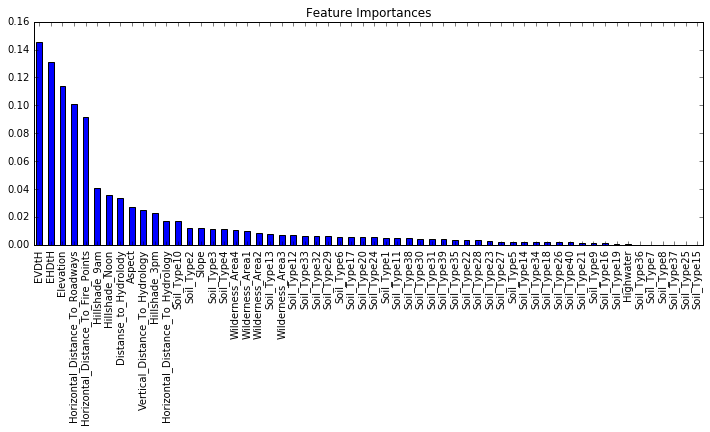

In [27]:
#Let's try GBM
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_fit, y_fit)
#Evaluate on development data
preds = gbm0.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
#print metrics.classification_report(y_eval.values, preds)

CV (f1) Score : Mean - 0.8205525 | Std - 0.009102414 | Min - 0.8067747 | Max - 0.8306151 


Model Report
Accuracy (Train): 0.9952
Accuracy (Dev) : 0.8344
             precision    recall  f1-score   support

          1       0.72      0.76      0.74       646
          2       0.74      0.62      0.67       683
          3       0.78      0.84      0.81       608
          4       0.94      0.96      0.95       645
          5       0.87      0.92      0.89       664
          6       0.85      0.79      0.82       644
          7       0.94      0.96      0.95       646

avg / total       0.83      0.83      0.83      4536



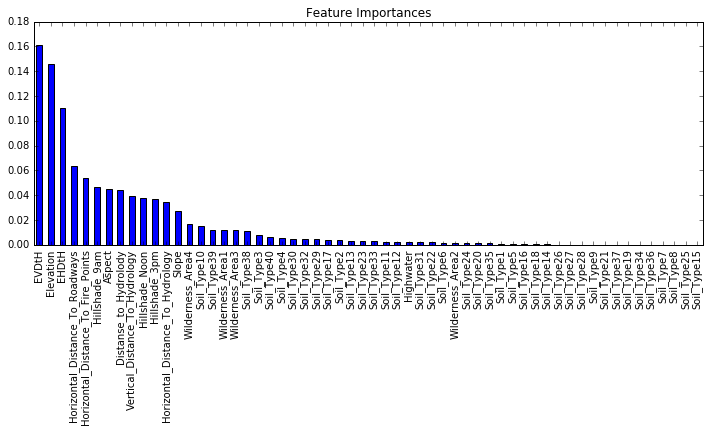

In [29]:
#let's try Random Forest model
rfc = RandomForestClassifier(random_state=10)
modelfit(rfc, X_fit, y_fit)
#Evaluate on development data
preds = rfc.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

In [67]:
#Let's try tuning random forest
#Start with max_features= sq.rt(features) - http://scikit-learn.org/stable/modules/ensemble.html (1.11.2.3)
print "-------Find the best parameters for RandomForest-------------"
#tune_params = {'n_estimators': [100,200,300,400,500,600], 'max_features':[8,9,10,11,12,13,14,15]}
#clf = GridSearchCV(RandomForestClassifier(), tune_params)
#clf.fit(X_fit, y_fit)
#print 'Best parametrs for RandomForest:', clf.best_params_
#The output from above - Best parametrs for RandomForest: {'max_features': 9, 'n_estimators': 100}
trfc = ExtraTreesClassifier(max_features=9, n_estimators=400, min_samples_split=1, random_state=0, 
                            oob_score=True, bootstrap=True)
modelfit(trfc, X_fit, y_fit, performCV=False, printFeatureImportance=False)
print 'oob score:', trfc.oob_score_
#Evaluate on development data
preds = trfc.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)


-------Find the best parameters for RandomForest-------------

Model Report
Accuracy (Train): 1
oob score: 0.857520786092
Accuracy (Dev) : 0.853
             precision    recall  f1-score   support

          1       0.77      0.76      0.77       642
          2       0.77      0.64      0.70       653
          3       0.86      0.81      0.83       647
          4       0.93      0.98      0.95       681
          5       0.86      0.96      0.91       640
          6       0.84      0.85      0.84       659
          7       0.92      0.97      0.94       614

avg / total       0.85      0.85      0.85      4536



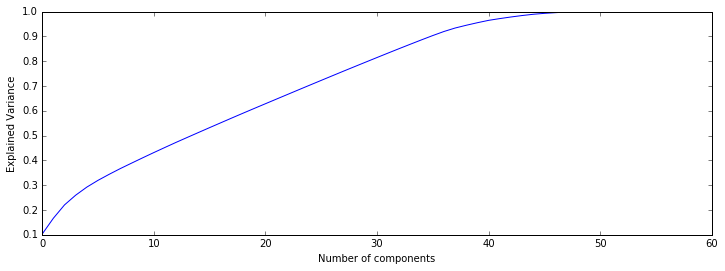

Fraction of the total variance explained: 
0.955230604438

Model Report
Accuracy (Train): 1
Accuracy (Dev) : 0.8122
             precision    recall  f1-score   support

          1       0.71      0.72      0.72       642
          2       0.71      0.60      0.65       653
          3       0.77      0.77      0.77       647
          4       0.91      0.94      0.93       681
          5       0.86      0.93      0.89       640
          6       0.78      0.78      0.78       659
          7       0.92      0.94      0.93       614

avg / total       0.81      0.81      0.81      4536



In [59]:
#Lets do some PCA to reduce the number of components. Let us draw a curve of explained variance vs number of components
pca_mod = PCA()
pca_mod.fit(X_fit) 
explained_variance = np.cumsum(pca_mod.explained_variance_ratio_)
plt.plot(explained_variance)
plt.ylabel('Explained Variance')
plt.xlabel('Number of components')
plt.show()

pca_mod = PCA(n_components = 40)
X_fit_transformed = pca_mod.fit_transform(X_fit) 
X_eval_transformed = pca_mod.transform(X_eval)
test_transformed = pca_mod.transform(test[predictors])
explained_variance = np.cumsum(pca_mod.explained_variance_ratio_)
print 'Fraction of the total variance explained: \n', explained_variance[len(explained_variance) - 1]

pca_trfc = RandomForestClassifier(max_features=9, n_estimators=100)
modelfit(pca_trfc, X_fit_transformed, y_fit,performCV=False,printFeatureImportance=False)
#Evaluate on development data
preds = pca_trfc.predict(X_eval_transformed)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

In [60]:
#Submission of test values -- Run this once after finalizing model
preds = trfc.predict(test_transformed)
#preds = trfc.predict(test[predictors])
submission = pd.DataFrame({"Id":test[IDcol], "Cover_Type":preds})
submission.to_csv("submission_4.csv", index=False)

In [96]:
#Next Steps
    
#Tried few models learned so far in the class.
#Next steps include feature engineering to find more relevant features
#Also, to try other types of models, particularly neural networks. Continue tuning of the above models by performing gridsearch
#Currnet accuracy benchmark is 0.83 on dev data and 0.59 on public leaderboard